In [1]:
#import libraries
import pandas as pd
import numpy as np

import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')

from textblob import Word

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import  LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score, classification_report,accuracy_score

from lightgbm import LGBMClassifier

import gensim
from gensim.models.word2vec import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

import matplotlib.pyplot as plt
import pickle
import seaborn as sn

import emoji

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /home/kalit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Processing Data

In [2]:
# Retrieve data from the given path

filePath = '../data/en_Hasoc2021_train.csv'
filePath = '../../data/english/english_2021.csv'
df1 = pd.read_csv(filePath,delimiter=',')

df1 = df1.drop('task_2',axis=1)
df1.columns = ['TwitterID','HASOCID','Text','Type']
df1 = df1.drop(['TwitterID','HASOCID'],axis=1)

filePath = '../../data/english/english_2020.xlsx'
df2 = pd.read_excel(filePath,engine='openpyxl')

df2 = df2.drop('task2',axis=1)
df2.columns = ['TwitterID','Text','Type','HASOCID']
df2 = df2.drop(['TwitterID','HASOCID'],axis=1)


filePath = '../../data/english/english_2019_1.tsv'
df3 = pd.read_csv(filePath,delimiter='\t')

df3 = df3.drop(['text_id','task_2','task_3'],axis=1)
df3.columns = ['Text','Type']

filePath = '../../data/english/english_2019_2.tsv'
df4 = pd.read_csv(filePath,delimiter='\t')

df4 = df4.drop(['text_id','task_2','task_3'],axis=1)
df4.columns = ['Text','Type']

In [3]:
df = pd.concat([df1,df2,df3,df4])

In [4]:
# Convert target variable to categorical value(integer)

df['Type'] = df['Type'].astype('category')
df['Type'] = df['Type'].cat.codes
df['Type'] = df['Type'].astype(np.int64)

In [5]:
def preprocess(txt):
    '''
        - Convert to lower case
        - Remove excessive spaces
        - Remove @handle
        - Remove website links/URLS
        - Search how to incorporate emojis?
    '''
    txt = txt.lower()
    #txt = emoji.demojize(txt)
    txt = re.sub(r'\s+',' ',txt)
    txt = re.sub(r'@[\w\-]+','',txt)
    txt = re.sub(r'https?:\/\/\S+','',txt)
    txt = re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)",'',txt)
    txt = re.sub(r'{link}', '', txt)
    txt = re.sub(r"\[video\]", '', txt)
    txt = re.sub(r'&[a-z]+;', '', txt)
    txt = re.sub(r"[^a-z\s\(\-:\)\\\/\];='#]", '', txt)
    txt = re.sub(r"[^\w\d'\s]+",'',txt)
    return txt

In [6]:
stop_words = stopwords.words('english')

def get_tokens(tweet):
    '''
        - Preprocess a given tweet text
        - Tokenize using RegexpTokenizer
        - Lemmatize each token, eg: rocks -> rock, better -> good
        - Remove stop words(or not)?
    '''
    tweet = preprocess(tweet)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(tweet)
    words = [Word(t).lemmatize() for t in tokens]
    words = [w for w in words if not w in stop_words]
    words = ' '.join(words)
    return words

In [7]:
df['Text'] = df['Text'].apply(lambda x: get_tokens(x))

In [8]:
X = df['Text']
Y = df['Type']

### Fetching GloVe and Word2Vec pretrained embeddings

In [9]:
def get_glove_embeddings(path):
    embeddings_dict = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            token = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[token] = vector        
    print('Found %s word vectors.' % len(embeddings_dict))
    return embeddings_dict

In [10]:
# glove_filename = './glove.6B/glove.6B.300d.txt'
# word2vec_output_file = glove_filename+'.word2vec'
# glove2word2vec(glove_filename, word2vec_output_file)

### Given tweet -> numeric vector representation

In [34]:
'''
    the ith value in the sentence embedding will be the mean of the ith values
    in the word embedding of all the words in the sentence
'''

class Word2VecVectorizer:
  def __init__(self, model):
    print("Loading in word vectors...")
    self.word_vectors = model
    print("Finished loading in word vectors")

  def fit(self, data):
    pass

  def transform(self, data):
    v = self.word_vectors.get_vector('king')
    self.D = v.shape[0]

    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = sentence.split()
      vecs = []
      m = 0
      for word in tokens:
        try:
          vec = self.word_vectors.get_vector(word)
          vecs.append(vec)
          m += 1
        except KeyError:
          pass
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    #print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X


  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)

### Training a classifier with given parameters and evaluating it's performance

In [12]:
def train_classifier(classifier,parameters,cv_fold=5,embedding_path=None,binary=False):
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)
    
    w2v_model = KeyedVectors.load_word2vec_format(embedding_path, binary=binary)
    vectorizer = Word2VecVectorizer(w2v_model)
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    X_train = np.array(X_train)
    X_test = np.array(X_test)    
    
    grid_search = GridSearchCV(classifier,param_grid = parameters,
                               cv = StratifiedKFold(n_splits=cv_fold,
                                                random_state=42,shuffle=True).split(X_train,Y_train))
    model = grid_search.fit(X_train,Y_train)
    evaluate(model,X_test,Y_test)   
    return model

In [13]:
def plot_confussion_matrix(y_test, y_pred):
    ''' Plot the confussion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
    sn.set(font_scale=1.4) 
    sn.heatmap(df_cm, annot=True,fmt='.0f',annot_kws={"size": 10})
    plt.show()

In [14]:
def evaluate(model,X_test,Y_test):
  print('Cross Validation Results:')
  print(model.cv_results_)

  y_pred = model.predict(X_test)
  
  print('Classification Report:')
  report = classification_report(Y_test, y_pred)
  print(report)
  plot_confussion_matrix(Y_test,y_pred)

### Logistic Regression Classifier

Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 34 / 11644
Numer of samples with no words found: 9 / 2912
Cross Validation Results:
{'mean_fit_time': array([0.22926016]), 'std_fit_time': array([0.02371964]), 'mean_score_time': array([0.00314465]), 'std_score_time': array([0.00390119]), 'params': [{}], 'split0_test_score': array([0.69042508]), 'split1_test_score': array([0.68956634]), 'split2_test_score': array([0.68012022]), 'split3_test_score': array([0.69858308]), 'split4_test_score': array([0.67568729]), 'mean_test_score': array([0.6868764]), 'std_test_score': array([0.00809589]), 'rank_test_score': array([1], dtype=int32)}
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.66      0.66      1377
           1       0.70      0.71      0.71      1535

    accuracy                           0.69      2912
   macro avg       0.69      0.68      0.68      2912
weighted avg       0

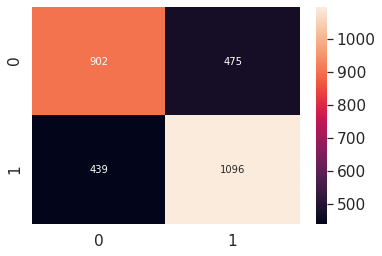

In [16]:
classifier_lr_1 = LogisticRegression(class_weight='balanced',penalty='l2',max_iter=400,
                                solver='liblinear', random_state=42, multi_class='ovr')
path = './glove.6B/glove.6B.100d.txt.word2vec'
classifier_lr_1 = train_classifier(classifier_lr_1,parameters=[{}],cv_fold=5,embedding_path=path,binary=False)

Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 30 / 11644
Numer of samples with no words found: 5 / 2912
Cross Validation Results:
{'mean_fit_time': array([0.70240054]), 'std_fit_time': array([0.05471869]), 'mean_score_time': array([0.00324092]), 'std_score_time': array([0.00287335]), 'params': [{}], 'split0_test_score': array([0.73293259]), 'split1_test_score': array([0.71060541]), 'split2_test_score': array([0.721769]), 'split3_test_score': array([0.73078574]), 'split4_test_score': array([0.71434708]), 'mean_test_score': array([0.72208796]), 'std_test_score': array([0.00877644]), 'rank_test_score': array([1], dtype=int32)}
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.67      0.70      1377
           1       0.72      0.79      0.75      1535

    accuracy                           0.73      2912
   macro avg       0.73      0.73      0.73      2912
weighted avg       0.

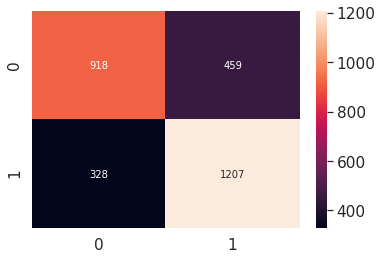

In [17]:
classifier_lr_2 = LogisticRegression(class_weight='balanced',penalty='l2',max_iter=400,
                                solver='liblinear', random_state=42, multi_class='ovr')
path = './GoogleNews-vectors-negative300.bin'
classifier_lr_2 = train_classifier(classifier_lr_2,parameters=[{}],cv_fold=5,embedding_path=path,binary=True)

### Support Vector Classifier

Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 34 / 11644
Numer of samples with no words found: 9 / 2912
Cross Validation Results:
{'mean_fit_time': array([ 9.38750477, 10.02034545,  9.87656412, 10.20071454,  9.33368473,
        9.39052668,  9.55862522,  8.90761843,  7.57844939,  8.74406719,
        6.7439713 ,  8.31769037]), 'std_fit_time': array([0.20912149, 0.28685937, 0.33079094, 0.15376153, 0.4417852 ,
       1.34731236, 0.52343094, 0.3805974 , 0.09109339, 0.3811244 ,
       0.09660022, 0.14608173]), 'mean_score_time': array([2.56709642, 2.67880945, 2.69060411, 2.72967434, 2.47197533,
       2.27925282, 2.56933732, 2.37419152, 1.93164158, 1.80174198,
       1.84273467, 1.80564265]), 'std_score_time': array([0.15506488, 0.06818958, 0.14642487, 0.10193915, 0.12597567,
       0.32395775, 0.13363256, 0.15391062, 0.05154199, 0.032263  ,
       0.01457747, 0.048154  ]), 'param_C': masked_array(data=[0.001, 0.001, 0.001, 0.001, 0.1, 0.1,

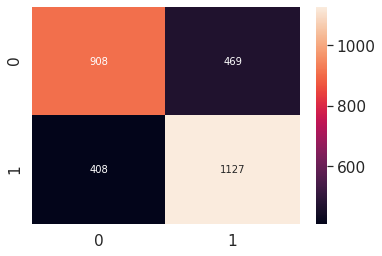

In [18]:
classifier_svc_1 = SVC(kernel='rbf')
path = './glove.6B/glove.6B.100d.txt.word2vec'
params = {'C':[0.001,0.1,10],'gamma':[0.01,0.1,'auto','scale']}
classifier_svc_1 = train_classifier(classifier_svc_1,parameters=params,cv_fold=5,embedding_path=path,binary=False)

Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 30 / 11644
Numer of samples with no words found: 5 / 2912
Cross Validation Results:
{'mean_fit_time': array([21.05791636, 22.7717103 , 19.91741343, 19.37301488, 16.99665518,
       18.08545356, 19.25108376, 16.53631177, 13.63108425, 12.67802691,
       14.31097484, 22.52446117]), 'std_fit_time': array([0.52485784, 0.51388455, 1.33054898, 0.68683494, 0.21847878,
       1.06460234, 0.1857663 , 2.50516079, 0.31629082, 0.15466716,
       0.15784873, 2.71166772]), 'mean_score_time': array([8.26473007, 8.4420083 , 7.73559461, 7.38690395, 6.76589675,
       6.99338088, 8.00415626, 6.24987135, 5.32439971, 4.88924832,
       5.66818414, 5.63290644]), 'std_score_time': array([0.27797561, 0.03935921, 0.42638581, 0.25321524, 0.10948239,
       0.53569607, 0.26752541, 0.54683059, 0.10035166, 0.12052178,
       0.18737517, 0.14788913]), 'param_C': masked_array(data=[0.001, 0.001, 0.001, 0.001, 0.1, 0.1,

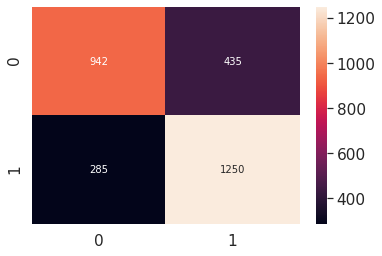

In [19]:
classifier_svc_2 = SVC(kernel='rbf')
path = './GoogleNews-vectors-negative300.bin'
params = {'C':[0.001,0.1,10],'gamma':[0.01,0.1,'auto','scale']}
classifier_svc_2 = train_classifier(classifier_svc_2,parameters=params,cv_fold=5,embedding_path=path,binary=True)

### Random Forest Classifier

Loading in word vectors...
Finished loading in word vectors
Cross Validation Results:
{'mean_fit_time': array([ 2.16924472,  4.17814431,  8.74392624,  3.49249539,  6.85171824,
       13.97069416]), 'std_fit_time': array([0.08778517, 0.02454365, 0.09413757, 0.15551412, 0.03777665,
       0.53868622]), 'mean_score_time': array([0.02489495, 0.0426055 , 0.08780231, 0.02296958, 0.04355111,
       0.08472495]), 'std_score_time': array([4.95524672e-03, 2.23010046e-04, 2.03675657e-03, 8.48664864e-04,
       8.53986729e-05, 1.26432107e-03]), 'param_max_features': masked_array(data=['log2', 'log2', 'log2', 'sqrt', 'sqrt', 'sqrt'],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[50, 100, 200, 50, 100, 200],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_features': 'log2', 'n_estimators': 50}, {'max_features': 'lo

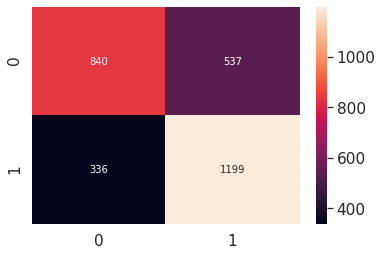

In [48]:
classifier_rf_1 = RandomForestClassifier()
path = './glove.6B/glove.6B.100d.txt.word2vec'
params = {'n_estimators':[50,100,200],'max_features':['log2','sqrt']}
classifier_rf_1 = train_classifier(classifier_rf_1,parameters=params,cv_fold=5,embedding_path=path,binary=False)

Loading in word vectors...
Finished loading in word vectors
Cross Validation Results:
{'mean_fit_time': array([ 2.82840681,  5.6548871 , 11.45508032,  5.69856877, 11.18684182,
       22.44462452]), 'std_fit_time': array([0.0292513 , 0.13662964, 0.18660934, 0.12401565, 0.167117  ,
       0.33461605]), 'mean_score_time': array([0.02594538, 0.05321064, 0.09596143, 0.02410579, 0.04577727,
       0.09179945]), 'std_score_time': array([0.00109804, 0.010947  , 0.00580167, 0.0003883 , 0.00063053,
       0.00377436]), 'param_max_features': masked_array(data=['log2', 'log2', 'log2', 'sqrt', 'sqrt', 'sqrt'],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[50, 100, 200, 50, 100, 200],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_features': 'log2', 'n_estimators': 50}, {'max_features': 'log2', 'n_estimators': 100

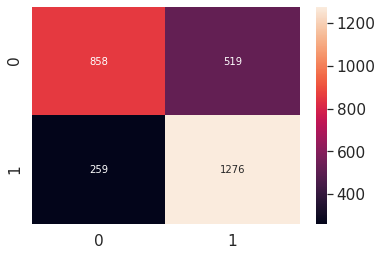

In [49]:
classifier_rf_2 = RandomForestClassifier()
path = './GoogleNews-vectors-negative300.bin'
params = {'n_estimators':[50,100,200],'max_features':['log2','sqrt']}
classifier_rf_2 = train_classifier(classifier_rf_2,parameters=params,cv_fold=5,embedding_path=path,binary=True)

### XGBoost Classifier

Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 9 / 3074
Numer of samples with no words found: 4 / 769
Cross Validation Results:
{'mean_fit_time': array([2.58718529]), 'std_fit_time': array([0.26724729]), 'mean_score_time': array([0.00964475]), 'std_score_time': array([0.00056047]), 'params': [{}], 'split0_test_score': array([0.72195122]), 'split1_test_score': array([0.71869919]), 'split2_test_score': array([0.72195122]), 'split3_test_score': array([0.72357724]), 'split4_test_score': array([0.74267101]), 'mean_test_score': array([0.72576997]), 'std_test_score': array([0.00859785]), 'rank_test_score': array([1], dtype=int32)}
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       529
           1       0.67      0.46      0.55       240

    accuracy                           0.76       769
   macro avg       0.73      0.68      0.69       769
weighted avg       0.7

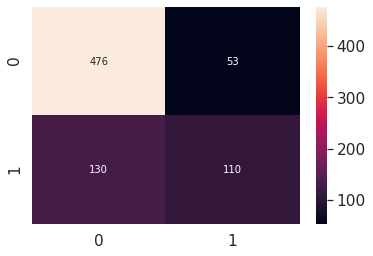

In [24]:
classifier = LGBMClassifier(learning_rate=0.05,n_estimators=1500,
                            colsample_bytree= 0.5,metric = 'f1_score')
path = './glove.6B/glove.6B.100d.txt.word2vec'
train_classifier(classifier,parameters=[{}],cv_fold=5,embedding_path=path,binary=False)

Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 5 / 3074
Numer of samples with no words found: 3 / 769
Cross Validation Results:
{'mean_fit_time': array([6.05439601]), 'std_fit_time': array([0.87776049]), 'mean_score_time': array([0.01164303]), 'std_score_time': array([0.00212442]), 'params': [{}], 'split0_test_score': array([0.75772358]), 'split1_test_score': array([0.75934959]), 'split2_test_score': array([0.72357724]), 'split3_test_score': array([0.74471545]), 'split4_test_score': array([0.74592834]), 'mean_test_score': array([0.74625884]), 'std_test_score': array([0.01280433]), 'rank_test_score': array([1], dtype=int32)}
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       529
           1       0.72      0.48      0.58       240

    accuracy                           0.78       769
   macro avg       0.76      0.70      0.71       769
weighted avg       0.7

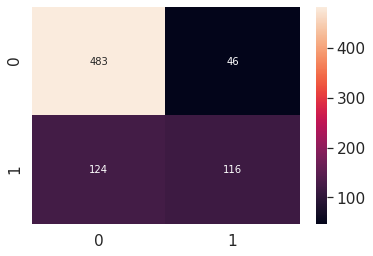

In [25]:
classifier = LGBMClassifier(learning_rate=0.05,n_estimators=1500,
                            colsample_bytree= 0.5,metric = 'f1_score')
path = './GoogleNews-vectors-negative300.bin'
train_classifier(classifier,parameters=[{}],cv_fold=5,embedding_path=path,binary=True)

### Predicting outputs

In [38]:
def get_predictions(filePath,model,output_file,vectorizer):
    df_test = pd.read_csv(filePath,delimiter=',')
    
    results = {}

    for ind in df_test.index:
        txt = df_test['text'][ind]
        id = df_test['_id'][ind]

        txt = get_tokens(txt)        
    
        txt = vectorizer.transform([txt])
        txt = np.array(txt)
        output = model.predict(txt)
        if(output[0]==0):
          results[id] = "HOF"
        else:
          results[id] = "NOT"
        
    df_results = pd.DataFrame(list(results.items()))
    df_results.columns = ["id","label"]
    df_results.to_csv(output_file,index=False)

In [35]:
path = './glove.6B/glove.6B.100d.txt.word2vec'
w2v_model_glove = KeyedVectors.load_word2vec_format(path, binary=False)
vectorizer_glove = Word2VecVectorizer(w2v_model_glove)

Loading in word vectors...
Finished loading in word vectors


In [36]:
path = './GoogleNews-vectors-negative300.bin'
w2v_model_google = KeyedVectors.load_word2vec_format(path, binary=True)
vectorizer_google = Word2VecVectorizer(w2v_model_google)

Loading in word vectors...
Finished loading in word vectors


In [28]:
filePath = '../../data/english/en_Hasoc2021_test_task1.csv'

In [39]:
output_file_path = "../../data/english/classifier_using_word_embeddings_glove_en_lr.csv"
get_predictions(filePath,classifier_lr_1,output_file_path,vectorizer_glove)

In [41]:
output_file_path = "../../data/english/classifier_using_word_embeddings_google_en_lr.csv"
get_predictions(filePath,classifier_lr_2,output_file_path,vectorizer_google)

In [42]:
output_file_path = "../../data/english/classifier_using_word_embeddings_glove_en_svc.csv"
get_predictions(filePath,classifier_svc_1,output_file_path,vectorizer_glove)

In [43]:
output_file_path = "../../data/english/classifier_using_word_embeddings_google_en_svc.csv"
get_predictions(filePath,classifier_svc_2,output_file_path,vectorizer_google)

In [50]:
output_file_path = "../../data/english/classifier_using_word_embeddings_glove_en_rf.csv"
get_predictions(filePath,classifier_rf_1,output_file_path,vectorizer_glove)

In [51]:
output_file_path = "../../data/english/classifier_using_word_embeddings_google_en_rf.csv"
get_predictions(filePath,classifier_rf_2,output_file_path,vectorizer_google)